<a href="https://colab.research.google.com/github/pascale25/AWM2dtxtv4vh3v1w_CNN_project/blob/master/MonReader_CNN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MonReader_CNN_project

- Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

- Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber


- Goal(s):

Predict if the page is being flipped using a single image.

- Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

- Bonus(es):

Predict if a given sequence of images contains an action of flipping.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
#Importing Necessary files to read Images
import pandas as pd
import numpy as np
import os
import pathlib
import zipfile
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# library of computeur vision
import torchvision
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
# Check PyTorch version
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


# Get the data and data directory

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
os.listdir("gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w")

['images.zip',
 'images',
 '04-pizza-dad.jpeg',
 'models',
 'MonReader_CNN_project.ipynb',
 'image_test']

In [9]:
!ls gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images

testing  training


In [8]:
import zipfile
from pathlib import Path
# Setup path to data folder
data_path = Path("gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w")
image_path = data_path /"images"

In [10]:
# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images directory exists.


In [11]:
image_path2 = "gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images"

In [12]:
# explore data in directories (googlecolab)
import os
def  walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [13]:
walk_through_dir(image_path2)

There are 2 directories and 0 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images'.
There are 2 directories and 0 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing'.
There are 0 directories and 290 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing/flip'.
There are 0 directories and 307 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing/notflip'.
There are 2 directories and 0 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training'.
There are 0 directories and 1162 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training/flip'.
There are 0 directories and 1230 images in 'gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training/notflip'.


In [14]:
# Setup train and testing paths
train_dir = image_path / "training"
test_dir = image_path / "testing"

train_dir, test_dir

(PosixPath('gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training'),
 PosixPath('gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing'))

In [15]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['flip', 'notflip']
['flip', 'notflip']


In the test folder, there are 290 flipped and 307 non-flipped images, while in the training folder, there are 1162 flipped and 1230 non-flipped images.

# EDA  -   Visualize data 

Random image path: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing/flip/0034_000000015.jpg
Image class: flip
Image height: 1920
Image width: 1080


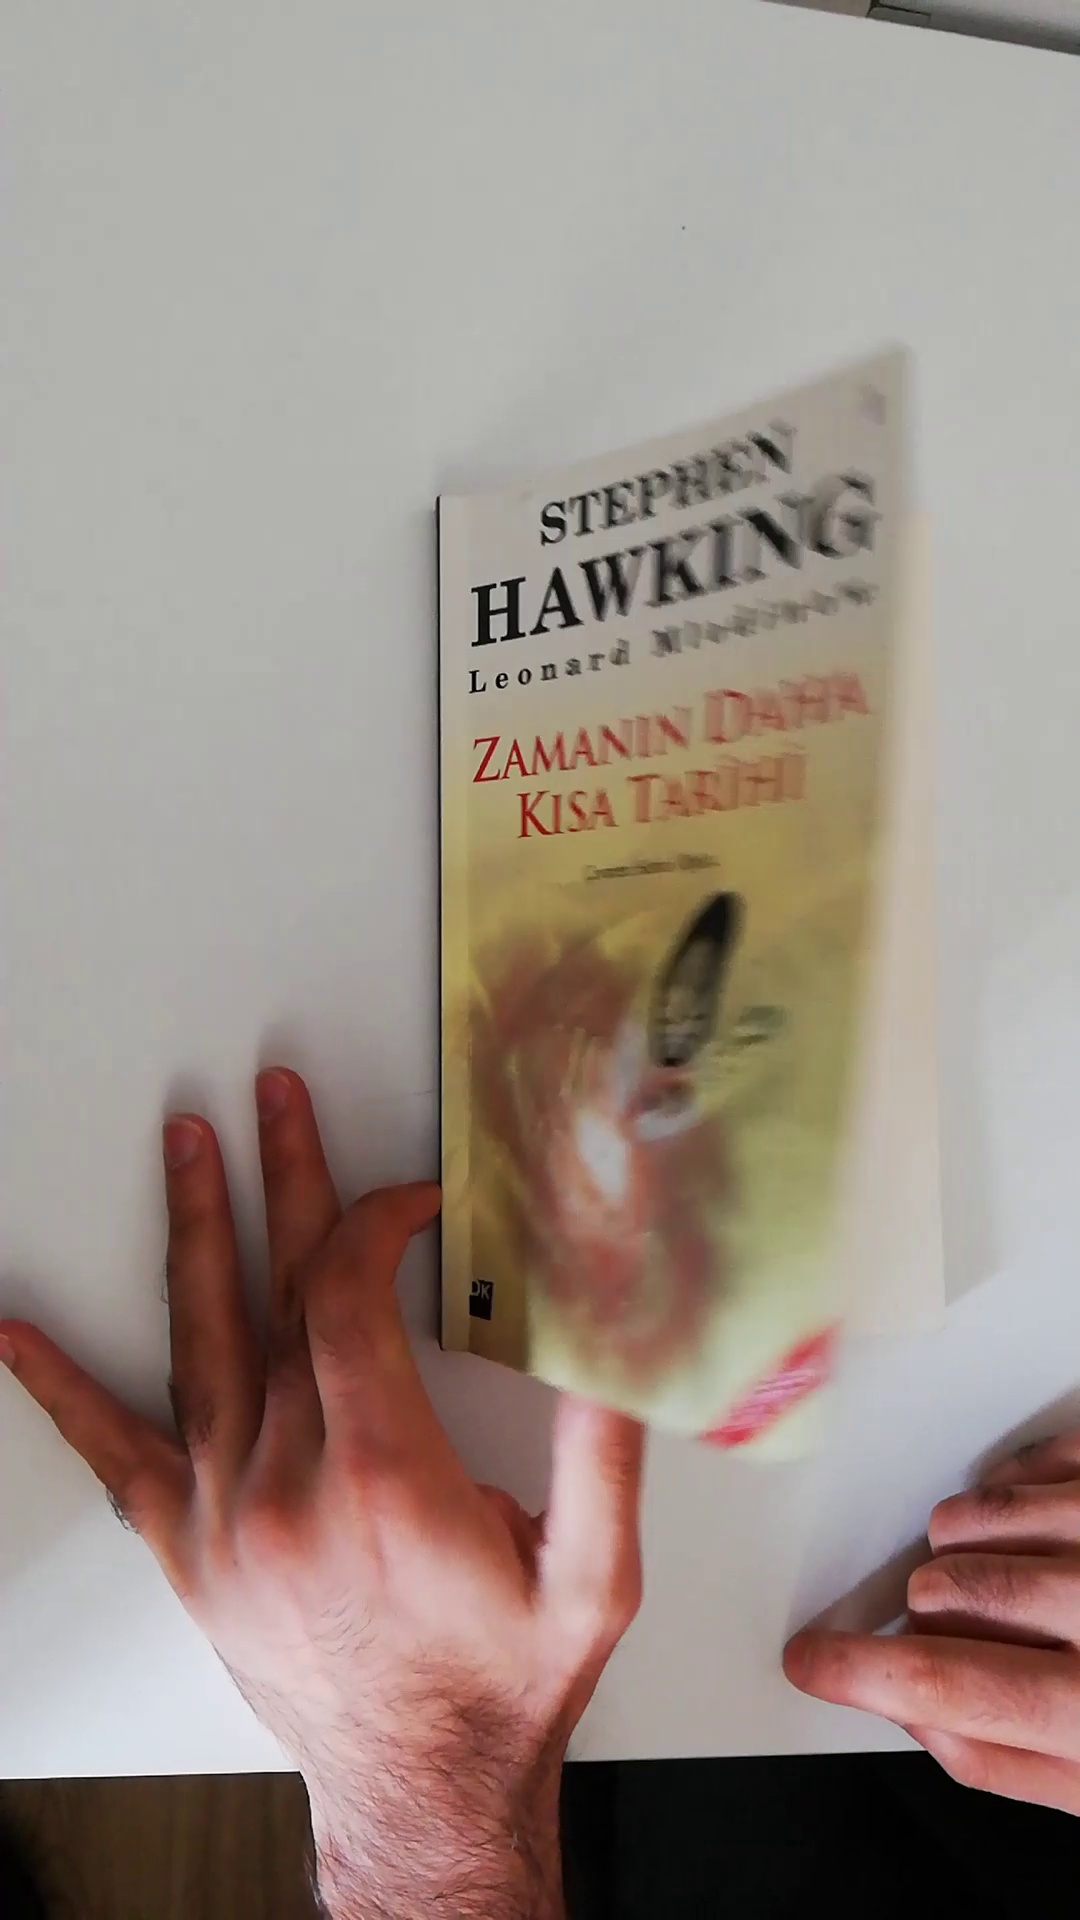

In [ ]:
import random
from PIL import Image

# Set seed
#random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg")) # * any file in the directory

# 2. Get random image in the path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem #name of folder containing the image

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [ ]:
import numpy as np
np.asarray(img).shape

(1920, 1080, 3)

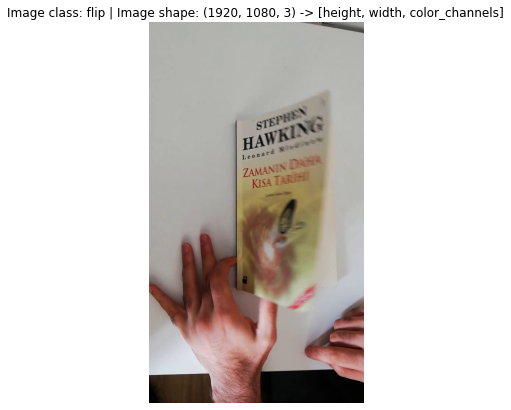

In [ ]:
# visualize the image (img) with matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Visualize image with pytorch

Turn image into tensors (numerical representations of our images) and plot

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off") # or False 

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) # reorganze color, heigth , witdh, 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

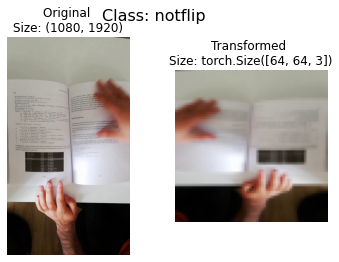

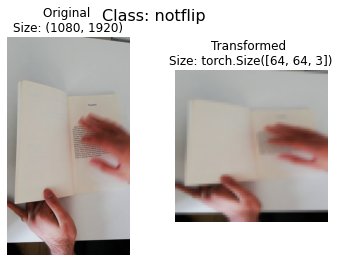

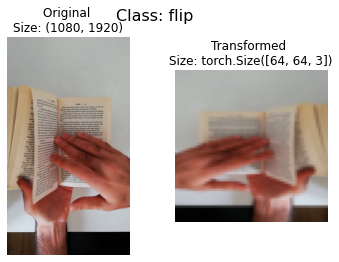

In [ ]:
plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# Loading Image Data Using ImageFolder and visualize

---



In [19]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [20]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2392
    Root location: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 597
    Root location: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [21]:
# Get class names as a list
class_names = train_data.classes
class_names

['flip', 'notflip']

In [22]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'flip': 0, 'notflip': 1}

In [23]:
# Check the lengths
len(train_data), len(test_data)

(2392, 597)

In [24]:
# index on our train_data and test_data Dataset's to find samples and their target labels.
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.5569, 0.5529, 0.5529,  ..., 0.5961, 0.5882, 0.5922],
         [0.5529, 0.5490, 0.5529,  ..., 0.6000, 0.5961, 0.6000],
         [0.5373, 0.5373, 0.5373,  ..., 0.5961, 0.6000, 0.6000],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0039, 0.0039],
         [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0039, 0.0039],
         [0.0157, 0.0157, 0.0118,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.5412, 0.5412, 0.5412,  ..., 0.5804, 0.5882, 0.5843],
         [0.5333, 0.5373, 0.5373,  ..., 0.5882, 0.5882, 0.5882],
         [0.5216, 0.5216, 0.5255,  ..., 0.5882, 0.5882, 0.5804],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
         [0.0118, 0.0157, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
         [0.0157, 0.0157, 0.0118,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.4588, 0.4471, 0.4510,  ..., 0.5020, 0.4980, 0.5059],
         [0.4549, 0.4549, 0.4510,  ..., 0.4980, 0.4980, 0.5098],
         [0.4353, 0.4314, 0.4314,  ..., 0.50

In [ ]:
class_names[label]

'flip'

In [ ]:
import numpy as np
np.asarray(img).shape

(3, 64, 64)

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


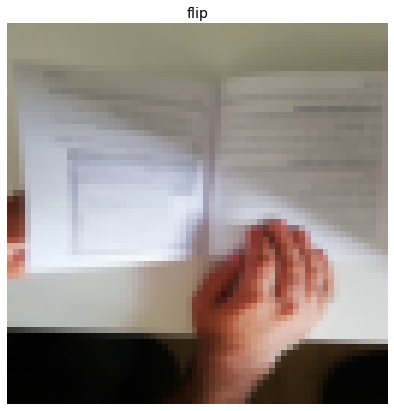

In [ ]:
#How about we plot a single image tensor using matplotlib?

# Rearrange the order of dimensions , torch.tensor image fron train_data
img_permute = img.permute(1, 2, 0)  # 'JpegImageFile' object has no attribute 'permute'

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [25]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more), how many cpu 
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size= BATH_SIZE, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f682695d1f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f682695d340>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
len(train_dataloader), len(test_dataloader)

(2392, 597)

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
#class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))]) # ok
print(f"Class names found: {class_names_found}")

Target directory: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training
Class names found: ['flip', 'notflip']


In [ ]:
# Create a function to display random images
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

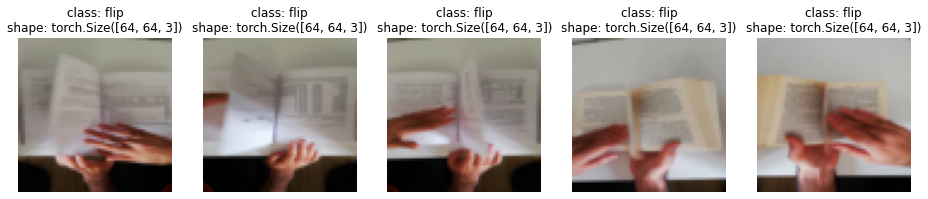

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

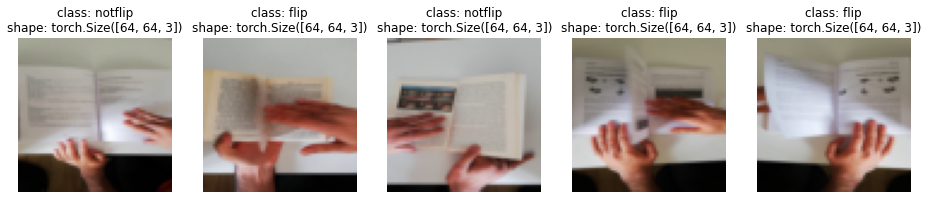

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

# Model 0

In [ ]:
# simple transformation
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)), 
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f6e9b4bda00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6e9b4bda90>)

In [ ]:
#import os
#os.cpu_count() # can replace 1 in num_workers 

In [67]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,     ### *56*56,)
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

#torch.manual_seed(42)
#model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
#                  hidden_units=10, 
#                  output_shape=len(train_data.classes)).to(device)
#model_0

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device) # send to target device
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

## Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device = device):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # output model logits

        # 2. Calculate  and accumulate the train loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # give the label 
        train_acc += (y_pred_class == y).sum().item()/len(y_pred) # total number that are rigth and divide 

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device = device):
   
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate the test loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy 
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Create train() function to combine train_step() and test_step()

In [ ]:
#  Creating a train() function to combine train_step() and test_step()

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), # multiclass classification
          epochs: int = 5,
          device=device):
    
    # 2. Create empty results dictionary to track the results
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# train and evaluate model zero
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001) # default of Adm is 0.001

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6942 | train_acc: 0.4999 | test_loss: 0.6913 | test_acc: 0.6234
Epoch: 2 | train_loss: 0.6440 | train_acc: 0.6285 | test_loss: 0.5002 | test_acc: 0.7927
Epoch: 3 | train_loss: 0.4124 | train_acc: 0.8306 | test_loss: 0.3144 | test_acc: 0.8519
Epoch: 4 | train_loss: 0.2812 | train_acc: 0.8886 | test_loss: 0.2628 | test_acc: 0.9160
Epoch: 5 | train_loss: 0.2269 | train_acc: 0.9169 | test_loss: 0.2381 | test_acc: 0.9234
Epoch: 6 | train_loss: 0.1687 | train_acc: 0.9479 | test_loss: 0.2107 | test_acc: 0.9374
Epoch: 7 | train_loss: 0.1556 | train_acc: 0.9383 | test_loss: 0.1654 | test_acc: 0.9308
Epoch: 8 | train_loss: 0.1545 | train_acc: 0.9467 | test_loss: 0.1611 | test_acc: 0.9432
Epoch: 9 | train_loss: 0.1171 | train_acc: 0.9642 | test_loss: 0.1331 | test_acc: 0.9522
Epoch: 10 | train_loss: 0.0978 | train_acc: 0.9693 | test_loss: 0.1432 | test_acc: 0.9399
Epoch: 11 | train_loss: 0.1113 | train_acc: 0.9571 | test_loss: 0.1220 | test_acc: 0.9654
Epoch: 12 | train_l

In [ ]:
#Use torchinfo to get an idea of the shapes going through our model
#torchinfo comes with a summary() method that takes a PyTorch model as well as an input_shape 
#and returns what happens as a tensor moves through your model.

try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size
# batch of one image 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [ ]:
#summary(model_0, input_size=[1, 3, 224, 224]) # review up to 56*56 

In [ ]:
# Check the model_0_results keys
model_0_results

{'train_loss': [0.6942069737116495,
  0.6440055612723032,
  0.41236189285914104,
  0.281245420674483,
  0.22685431867837905,
  0.16869486192862193,
  0.15560788489878177,
  0.15447696655988694,
  0.11710876715679963,
  0.0978338684886694,
  0.11130805642654498,
  0.09741005927324295,
  0.10124026608963807,
  0.07138387072831393,
  0.07443350649128358,
  0.06903572951753935,
  0.0716319946354876,
  0.06827734957759579,
  0.04657332985972365,
  0.0379391237317274],
 'train_acc': [0.49986111111111114,
  0.6284722222222222,
  0.8305555555555555,
  0.888611111111111,
  0.9169444444444443,
  0.9479166666666666,
  0.9383333333333334,
  0.9466666666666667,
  0.9641666666666666,
  0.9693055555555556,
  0.9570833333333333,
  0.9636111111111111,
  0.9636111111111111,
  0.9752777777777777,
  0.9716666666666667,
  0.97625,
  0.97625,
  0.9768055555555556,
  0.9829166666666667,
  0.9854166666666667],
 'test_loss': [0.6912745676542583,
  0.5002092679864482,
  0.3143859631136844,
  0.2627918849650182,

In [ ]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

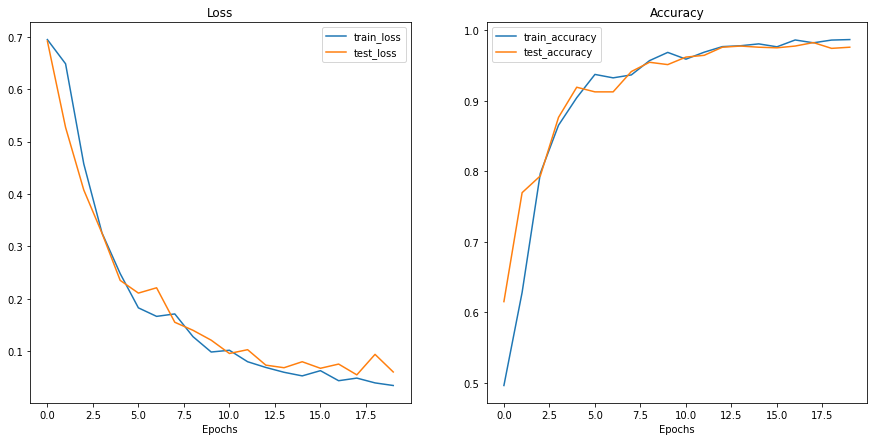

In [ ]:
plot_loss_curves(model_0_results)

## calculate F1 score

In [ ]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1


In [ ]:
model_0.eval()
test_loss2 = 0
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader_simple):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits = model_0(X)

In [ ]:
test_pred_labels = test_pred_logits.argmax(dim=1)
y_pred = test_pred_labels
y_pred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [ ]:
y_true = y
y_true

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [ ]:
f1_loss(y_true, y_pred, is_training=False)

tensor(0.9756, device='cuda:0')

In [ ]:
y_true2 = y.detach().cpu().numpy()
y_true2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_pred_labels = test_pred_logits.argmax(dim=1)
y_pred2 = test_pred_labels.detach().cpu().numpy()
y_pred2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import f1_score   
f1_score = f1_score(y_true2, y_pred2)
f1_score

0.975609756097561

In [ ]:
from sklearn.metrics import f1_score 
y_predd = test_pred_logits.argmax(dim=1).detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score = f1_score(y_truee, y_predd)
f1_score

0.975609756097561

# Save the Model 

In [ ]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  
  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  
  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
#model_0.state_dict()

In [ ]:
#Saving and Loading Model Weights
# Save the model
save_model(model=model_0,
           target_dir= data_path / "models",
           model_name="tinyvgg_model_0.pth")

[INFO] Saving model to: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/tinyvgg_model_0.pth


In [ ]:
# Setup the best model filepath
best_model_path = "gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/tinyvgg_model_0.pth"

# Load the saved best model state_dict()
torch.manual_seed(42)
model_s = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device) # send to target device
model_s
model_s.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
# verify the save model contain    it is ok 
#model_s.state_dict() 

In [ ]:
# test the save model 
model_s.eval()
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader_simple):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits2 = model_s(X)

In [ ]:
from sklearn.metrics import f1_score 
test_pred_labels = test_pred_logits2.argmax(dim=1)
y_predd = test_pred_labels
y_predd = y_predd.detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score = f1_score(y_truee, y_predd)
f1_score

0.975609756097561

In [ ]:
# # Save the model
#PATH = "gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models"
#torch.save(model_0, PATH)
MODEL_NAME = "tinyvgg2_model_0.pth"
MODEL_SAVE_PATH = data_path / "models" / MODEL_NAME
# Save the model state dict
#print(f"Saving model to: {MODEL_SAVE_PATH}")
#torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
#           f=MODEL_SAVE_PATH)

In [ ]:
# load trained model 

In [58]:
#Saving and Loading Models with Shapes
PATH = "gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/tinyvgg2_model_0.pth"
#torch.save( model_0, PATH) # to save
model_load = torch.load(PATH)
model_load

In [ ]:
# test the save model 
model_load.eval()
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader_simple):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits3 = model_load(X)

In [ ]:
from sklearn.metrics import f1_score 
test_pred_labels = test_pred_logits3.argmax(dim=1)
y_predd = test_pred_labels
y_predd = y_predd.detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score = f1_score(y_truee, y_predd)
f1_score

0.975609756097561

# Take a new picture (image) and make prediction with model 0

In [60]:
! ls gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/image_test

image_test


In [61]:
custom_image_path = data_path / "image_test"
custom_image_path 

PosixPath('gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/image_test')

In [62]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [63]:
test_data_custom = datasets.ImageFolder(root=custom_image_path, 
                                 transform=data_transform)

In [72]:
test_dataloader_custom = DataLoader(test_data_custom, 
                                    batch_size=1, 
                                    shuffle=False, 
                                    num_workers=1)

In [64]:
img2, label2 = test_data_custom[0][0], test_data_custom[0][1]

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


2

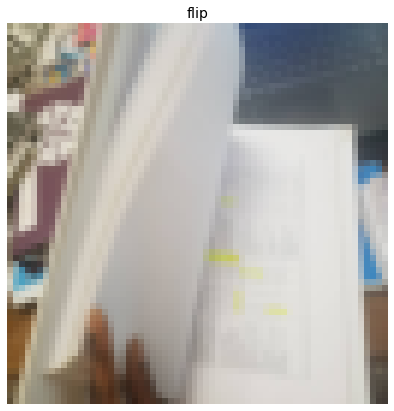

In [65]:
img_permute2 = img2.permute(1, 2, 0)  

# Print out different shapes (before and after permute)
print(f"Original shape: {img2.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute2.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img2.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label2], fontsize=14);2

In [68]:
# Loading Models with Shapes
PATH = Path("gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/tinyvgg2_model_0.pth")
model_load = torch.load(PATH)
model_load

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [69]:
# Load the saved best model state_dict()
PATH2 = Path("gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/tinyvgg_model_0.pth")
torch.manual_seed(42)
model_load2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device) # send to target device
model_load2
model_load2.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

In [78]:
# test the save model 
model_load2.eval()
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader_custom):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits3 = model_load(X)

In [80]:
from sklearn.metrics import f1_score 
test_pred_labels = test_pred_logits3.argmax(dim=1)
y_predd = test_pred_labels
y_predd = y_predd.detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score = f1_score(y_truee, y_predd)
#f1_score

# Train your own models using timm

PyTorch Image Models (timm) is a library for state-of-the-art image classification, containing a collection of image models, optimizers, schedulers, augmentations and much more; it was recently named the top trending library on papers-with-code of 2021!

`timm` is a deep-learning library created by Ross Wightman and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results.

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.8 MB/s eta 0:00:00


In [ ]:
# https://timm.fast.ai/#Create-a-model
import timm 
import torch
#List Models with Pretrained Weights
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]

(770,
 ['adv_inception_v3',
  'bat_resnext26ts',
  'beit_base_patch16_224',
  'beit_base_patch16_224_in22k',
  'beit_base_patch16_384'])

In [ ]:
# query, the collection available models 
len(timm.list_models('*'))

964

In [ ]:
# use the pretrained argument to filter this selection to the models with pretrained weights
len(timm.list_models(pretrained=True))

770

In [ ]:
len(timm.list_models('resnet*', pretrained=True))

49

In [ ]:
# # To create a pretrained model, simply pass in pretrained=True.
pretrained_resnet_34_model = timm.create_model('resnet34', pretrained=True) # timm.create_model('resnet50d', pretrained=True, scriptable=True)
#timm.create_model('resnet34', pretrained=True, in_chans = 1)# in_chans : specify the number of input channel  1 for 1 colors channel 
#pretrained_resnet_34_model.eval()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


In [ ]:
#  understand more about how to use this model
pretrained_resnet_34_model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet34'}

In [ ]:
pretrained_resnet_34_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
pretrained_resnet_34_model.get_classifier()

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# Changing the number of classes
pretrained_resnet_34_model_0 = timm.create_model('resnet34', pretrained=True, num_classes = 2).to(device)
pretrained_resnet_34_model_0.get_classifier()

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
#Global pooling options
#avg : Average pooling
#max : Max pooling
#avgmax: the sum of average and max pooling, re-scaled by 0.5
#catavgmax: a concatenation of the outputs of average and max pooling along feature dimension. Note that this will double the feature dimension.
#‘’ : No pooling is used, the pooling layer is replaced by an Identity operation

pretrained_resnet_34_model_0.global_pool

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

In [ ]:
pretrained_resnet_34_model_0.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet34'}

In [ ]:
#  perform same data transforms on our own data as the pretrained model
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=manual_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=manual_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2392
    Root location: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 597
    Root location: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/images/testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:

from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f4ce7f9cb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4ce7f9ca90>)

In [ ]:
# test the save model 
pretrained_resnet_34_model_0.eval()
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits4 = pretrained_resnet_34_model_0(X)

In [ ]:
from sklearn.metrics import f1_score 
test_pred_labels = test_pred_logits4.argmax(dim=1)
y_predd = test_pred_labels
y_predd = y_predd.detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score1 = f1_score(y_truee, y_predd)
f1_score1

0.0

In [ ]:
#dir(pretrained_resnet_34_model_0)

In [ ]:
#pretrained_resnet_34_model_0.get_parameter

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
#for param in model.features.parameters():
#    param.requires_grad = False


In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_resnet_34_model_0.parameters(), lr=0.001) # default of Adm is 0.001

In [ ]:
# train and evaluate model zero
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results_02 = train(model=pretrained_resnet_34_model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2108 | train_acc: 0.9286 | test_loss: 0.2745 | test_acc: 0.8964
Epoch: 2 | train_loss: 0.0525 | train_acc: 0.9842 | test_loss: 0.1054 | test_acc: 0.9671
Epoch: 3 | train_loss: 0.0366 | train_acc: 0.9871 | test_loss: 0.0579 | test_acc: 0.9770
Epoch: 4 | train_loss: 0.0227 | train_acc: 0.9936 | test_loss: 0.1339 | test_acc: 0.9622
Epoch: 5 | train_loss: 0.0467 | train_acc: 0.9821 | test_loss: 0.1725 | test_acc: 0.9490
Total training time: 777.329 seconds


In [ ]:
model_0_results_02

{'train_loss': [0.210758684972922,
  0.05254967655986548,
  0.03663730989753579,
  0.022733745616860687,
  0.04670536704671879],
 'train_acc': [0.928611111111111,
  0.9841666666666666,
  0.9870833333333333,
  0.993611111111111,
  0.9820833333333333],
 'test_loss': [0.2744604582528011,
  0.10541053393573843,
  0.05791422573690254,
  0.13387836567284464,
  0.17254053021597907],
 'test_acc': [0.8963815789473685,
  0.9671052631578947,
  0.9769736842105263,
  0.962171052631579,
  0.9490131578947368]}

In [ ]:
# test the save model 
pretrained_resnet_34_model_0.eval()
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits5 = pretrained_resnet_34_model_0(X)

In [ ]:
from sklearn.metrics import f1_score 
test_pred_labels = test_pred_logits5.argmax(dim=1)
y_predd = test_pred_labels
y_predd = y_predd.detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score5 = f1_score(y_truee, y_predd)
f1_score5

1.0

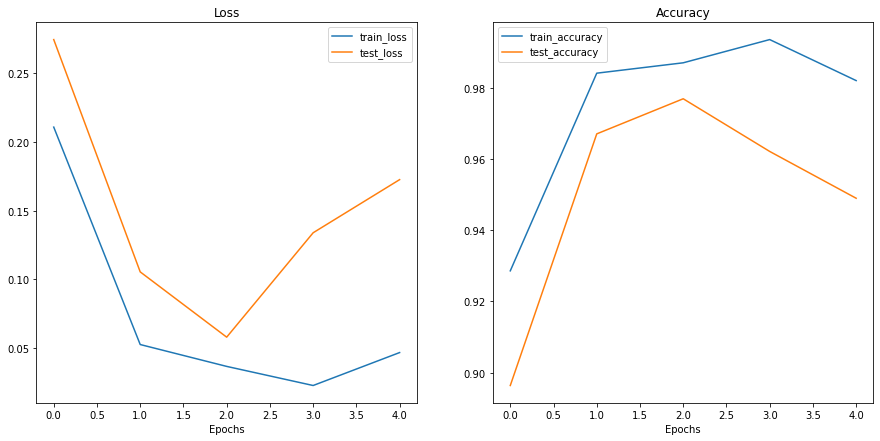

In [ ]:
plot_loss_curves(model_0_results_02)

In [ ]:
#      1.  Save the model dick 
MODEL_NAME = "pretrained_dick_model_0.pth"
MODEL_SAVE_PATH = data_path / "models" / MODEL_NAME
# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=pretrained_resnet_34_model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/pretrained_dick_model_0.pth


In [ ]:
#pretrained_resnet_34_model_0.state_dict()

In [ ]:
# Setup the model  dick filepath
pretrained_model_dick_path = "gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/pretrained_dick_model_0.pth"
pretrained_resnet_34_model_dick_load = timm.create_model('resnet34', pretrained=True, num_classes = 2).to(device)
pretrained_resnet_34_model_dick_load.load_state_dict(torch.load(pretrained_model_dick_path))

<All keys matched successfully>

In [ ]:
# test the save model dick
pretrained_resnet_34_model_dick_load.eval()
with torch.inference_mode():
  # Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    test_pred_logits6 = pretrained_resnet_34_model_dick_load(X)

In [ ]:
from sklearn.metrics import f1_score 
test_pred_labels = test_pred_logits6.argmax(dim=1)
y_predd = test_pred_labels
y_predd = y_predd.detach().cpu().numpy()
y_truee = y.detach().cpu().numpy()
f1_score6 = f1_score(y_truee, y_predd)
f1_score6

1.0

In [ ]:
#      2. Saving and Loading Models with Shapes
PATH = "gdrive/MyDrive/Apziva_project/AWM2dtxtv4vh3v1w/models/pretrained_resnet_34_model_0.pth"
#torch.save(pretrained_resnet_34_model_0, PATH) # to save
pretrained_model_load = torch.load(PATH)
#pretrained_model_load

In [ ]:

try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(pretrained_model_load, input_size=[1, 3, 244, 244]) # do a test pass through of an example input size
# batch of one image 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 122, 122]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 122, 122]         128
├─ReLU: 1-3                              [1, 64, 122, 122]         --
├─MaxPool2d: 1-4                         [1, 64, 61, 61]           --
├─Sequential: 1-5                        [1, 64, 61, 61]           --
│    └─BasicBlock: 2-1                   [1, 64, 61, 61]           --
│    │    └─Conv2d: 3-1                  [1, 64, 61, 61]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 61, 61]           128
│    │    └─Identity: 3-3                [1, 64, 61, 61]           --
│    │    └─ReLU: 3-4                    [1, 64, 61, 61]           --
│    │    └─Identity: 3-5                [1, 64, 61, 61]           --
│    │    └─Conv2d: 3-6                  [1, 64, 61, 61]           36,864
│ 